In [1]:
import os

import tqdm
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

import vari
import vari.datasets
import vari.models
import vari.inference
import vari.layers

SyntaxError: non-default argument follows default argument (spirals.py, line 42)

In [ ]:
experiments_dir = '/nas/experiments/sacred/models/'

## Visualize dataset

In [3]:
train_dataset = vari.datasets.Spirals(n_samples=10000)
x_train = train_dataset.examples
y_train = train_dataset.labels
y_train = np.argmax(y_train, -1)
y_train_onehot = np.eye(2)[y_train]

TypeError: make_data_spiral() got an unexpected keyword argument 'radius'

In [ ]:
test1_dataset = vari.datasets.Spirals(n_samples=10000, rounds=1.25, dist_from_center=0)
x_test1 = test1_dataset.examples
y_test1 = test1_dataset.labels
y_test1 = np.argmax(y_test1, -1)
y_test1_onehot = np.eye(2)[y_test1]

In [11]:
def make_meshgrid(x_lim, y_lim, nx=50, ny=50):
    """Returns a meshgrid over the 2D range specified by x_lim and y_lim"""
    x = np.linspace(np.min(x_train[:,0]), np.max(x_train[:,0]), nx)
    y = np.linspace(np.min(x_train[:,1]), np.max(x_train[:,1]), ny)
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    x_meshgrid = []
    for i in range(nx):   
        for j in range(ny):
            x_meshgrid += [[xv[j,i], yv[j,i]]]
            if not i == 0:
                x_meshgrid += [[xv[j,i-1], yv[j,i-1]]]
            x_meshgrid += [[xv[j,i], yv[j,i]]]
            if not j == 0:
                x_meshgrid += [[xv[j-1,i], yv[j-1,i]]]
            x_meshgrid += [[xv[j,i], yv[j,i]]]
            if j == ny-1:
                for k in range(ny):
                    x_meshgrid += [[xv[ny-(k+1),i], yv[ny-(k+1),i]]]

    return np.array(x_meshgrid)

In [12]:
x_train_meshgrid = make_meshgrid(
    x_lim=(x_train[:,0].min(), x_train[:,0].max()),
    y_lim=(x_train[:,1].min(), x_train[:,1].max()),
    nx=50,
    ny=50
)

In [13]:
x_train_meshgrid_large = make_meshgrid(
    x_lim=(x_train[:,0].min() - 5, x_train[:,0].max() + 5),
    y_lim=(x_train[:,1].min() - 5, x_train[:,1].max() + 5),
    nx=150,
    ny=150
)

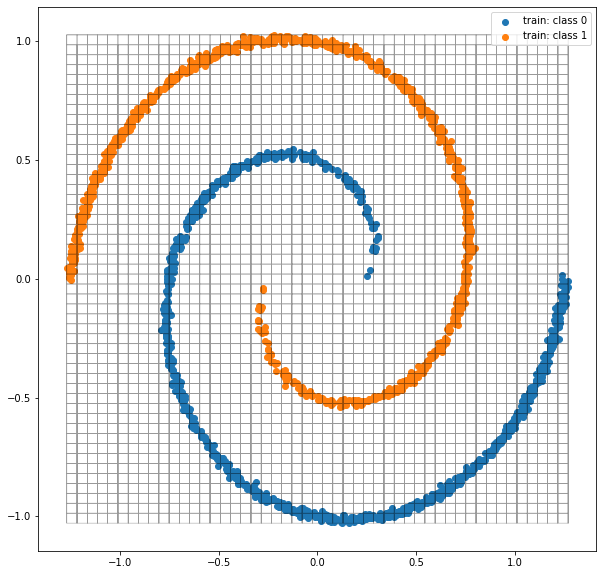

In [14]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(x_train_meshgrid[:,0], x_train_meshgrid[:,1], c="black", alpha=.4, linewidth=.5)
ax1.scatter(x_train[y_train==0,0], x_train[y_train==0,1], c='C0', label="train: class 0")
ax1.scatter(x_train[y_train==1,0], x_train[y_train==1,1], c='C1', label="train: class 1")
ax1.legend()
fig.show()

In [67]:
def make_data_spiral(n_samples=1000, shuffle=True, noise_var=.01, start_angle=0, rounds=1):
    theta = np.random.uniform(low=start_angle, high=start_angle + rounds * 2 * np.pi, size=n_samples)
    #theta = np.linspace(0, rounds * 2 * np.pi, n_samples)

    r_a = (2* (theta - start_angle)) / (4 * np.pi)
    data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
    x_a = data_a + noise_var * np.random.randn(n_samples, 2)

    r_b = (-2* (theta - start_angle)) / (4 * np.pi)
    data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
    x_b = data_b + noise_var * np.random.randn(n_samples, 2)

    res_a = np.append(x_a, np.zeros((n_samples, 1)), axis=1)
    res_b = np.append(x_b, np.ones((n_samples, 1)), axis=1)

    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)

    values = res[:, :2]# / np.abs(res[:, :2]).max()
    labels = np.identity(res[:, 2].astype(int).max() + 1)[res[:, 2].astype(int)]

    return values.astype(np.float32), labels.astype(np.float32)

In [226]:
def make_data_spiral(n_samples=1000, shuffle=True, noise=.05, rotation=0):
    rot_mat = np.array([[np.cos(rotation),-np.sin(rotation)],
                        [np.sin(rotation), np.cos(rotation)]])
    
    #theta = np.sqrt(np.random.rand(n_samples)) * 2 * np.pi
    theta = np.linspace(0, 2 * np.pi, n_samples)

    r_a = -theta - np.pi
    data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
    x_a = data_a + noise * np.random.randn(n_samples, 2)
    x_a = np.dot(x_a, rot_mat)

    r_b = theta + np.pi
    data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
    x_b = data_b + noise * np.random.randn(n_samples, 2)
    x_b = np.dot(x_b, rot_mat)
    
    print(x_b.shape)

    res_a = np.append(x_a, np.zeros((n_samples, 1)), axis=1)
    res_b = np.append(x_b, np.ones((n_samples, 1)), axis=1)

    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)

    values = res[:, :2]# / np.abs(res[:, :2]).max()
    labels = np.identity(res[:, 2].astype(int).max() + 1)[res[:, 2].astype(int)]
    return values.astype(np.float32), labels.astype(np.float32)

In [230]:
x_train, y_train = make_data_spiral()
values, labels = make_data_spiral(rotation=np.pi/2)

(1000, 2)
(1000, 2)


In [231]:
labels = np.argmax(labels, -1)
labels_onehot = np.eye(2)[labels]
y_train = np.argmax(y_train, -1)
y_train_onehot = np.eye(2)[y_train]

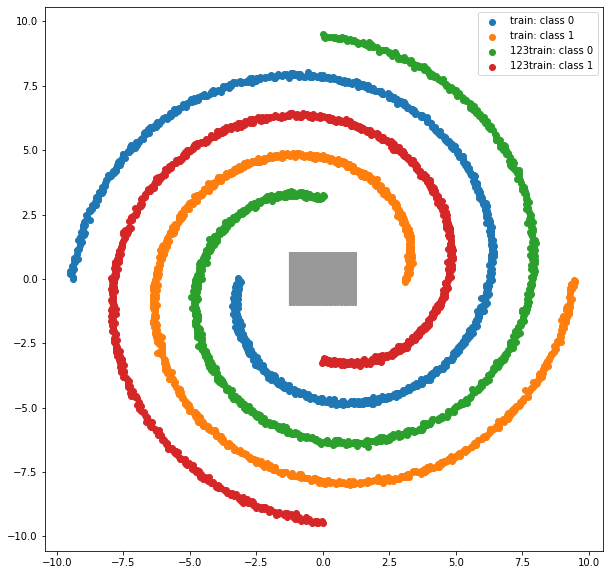

In [232]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1)

#ax1.plot(x_train_meshgrid[:,0], x_train_meshgrid[:,1], c="black", alpha=.4, linewidth=.5)
ax1.scatter(x_train[y_train==0,0], x_train[y_train==0,1], c='C0', label="train: class 0")
ax1.scatter(x_train[y_train==1,0], x_train[y_train==1,1], c='C1', label="train: class 1")

ax1.plot(x_train_meshgrid[:,0], x_train_meshgrid[:,1], c="black", alpha=.4, linewidth=.5)
ax1.scatter(values[labels==0,0], values[labels==0,1], c='C2', label="123train: class 0")
ax1.scatter(values[labels==1,0], values[labels==1,1], c='C3', label="123train: class 1")

ax1.legend()
fig.show()

## Load models

### VAE

In [315]:
vae_run_id = 5944

In [316]:
vae = vari.models.VariationalAutoencoder(x_dim=2, z_dim=2, h_dims=[64, 64, 64])
vae.load_state_dict(torch.load(
    os.path.join(experiments_dir, str(vae_run_id), 'model_state_dict.pkl'),
    map_location=torch.device('cpu')
))

<All keys matched successfully>

### AVAE

In [317]:
avae_run_id = 5945

In [318]:
avae = vari.models.AuxilliaryVariationalAutoencoder(x_dim=2, z_dim=2, a_dim=3, h_dims=[64, 64, 64])
avae.load_state_dict(torch.load(
    os.path.join(experiments_dir, str(avae_run_id), 'model_state_dict.pkl'),
    map_location=torch.device('cpu')
))

<All keys matched successfully>

In [319]:
models = dict(
    vae=vae,
    avae=avae
)

## Visualize latent space

In [320]:
def plot_vectors_and_mesh(vectors, mesh, fig=None, ax=None, figsize=(20, 20), label_ids=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
        
    if label_ids is not None:
        ax.scatter(vectors[label_ids==0, 0], vectors[label_ids==0, 1], c='C0', alpha=0.4, label="train:class0")
        ax.scatter(vectors[label_ids==1, 0], vectors[label_ids==1, 1], c='C1', alpha=0.4, label="train:class1")
    else:
        ax.scatter(vectors[:,0], vectors[:,1], c='C0', alpha=0.4, label="train")
    #ax1.scatter(vae_qz_mu_x2[:,0], vae_qz_mu_x2[:,1], c=[test1_0], alpha=0.4, label="test1")
    ax.plot(mesh[:,0], mesh[:,1], c='black', alpha=.2, linewidth=.5)
    ax.scatter(mesh[:,0], mesh[:,1], c=[(.8, .8, .8, .8)], alpha=.5, s=5.)
    # ax1.axis('off')
    ax.legend()
    return fig, ax

### VAE

In [321]:
with torch.no_grad():
    vae_qz_x_train, vae_qz_mu_x_train, vae_qz_log_var_x_train = vae.decoder(torch.FloatTensor(train_dataset.examples))
    vae_qz_mesh, vae_qz_mu_mesh, vae_qz_log_var_mesh = vae.decoder(torch.FloatTensor(x_train_meshgrid))

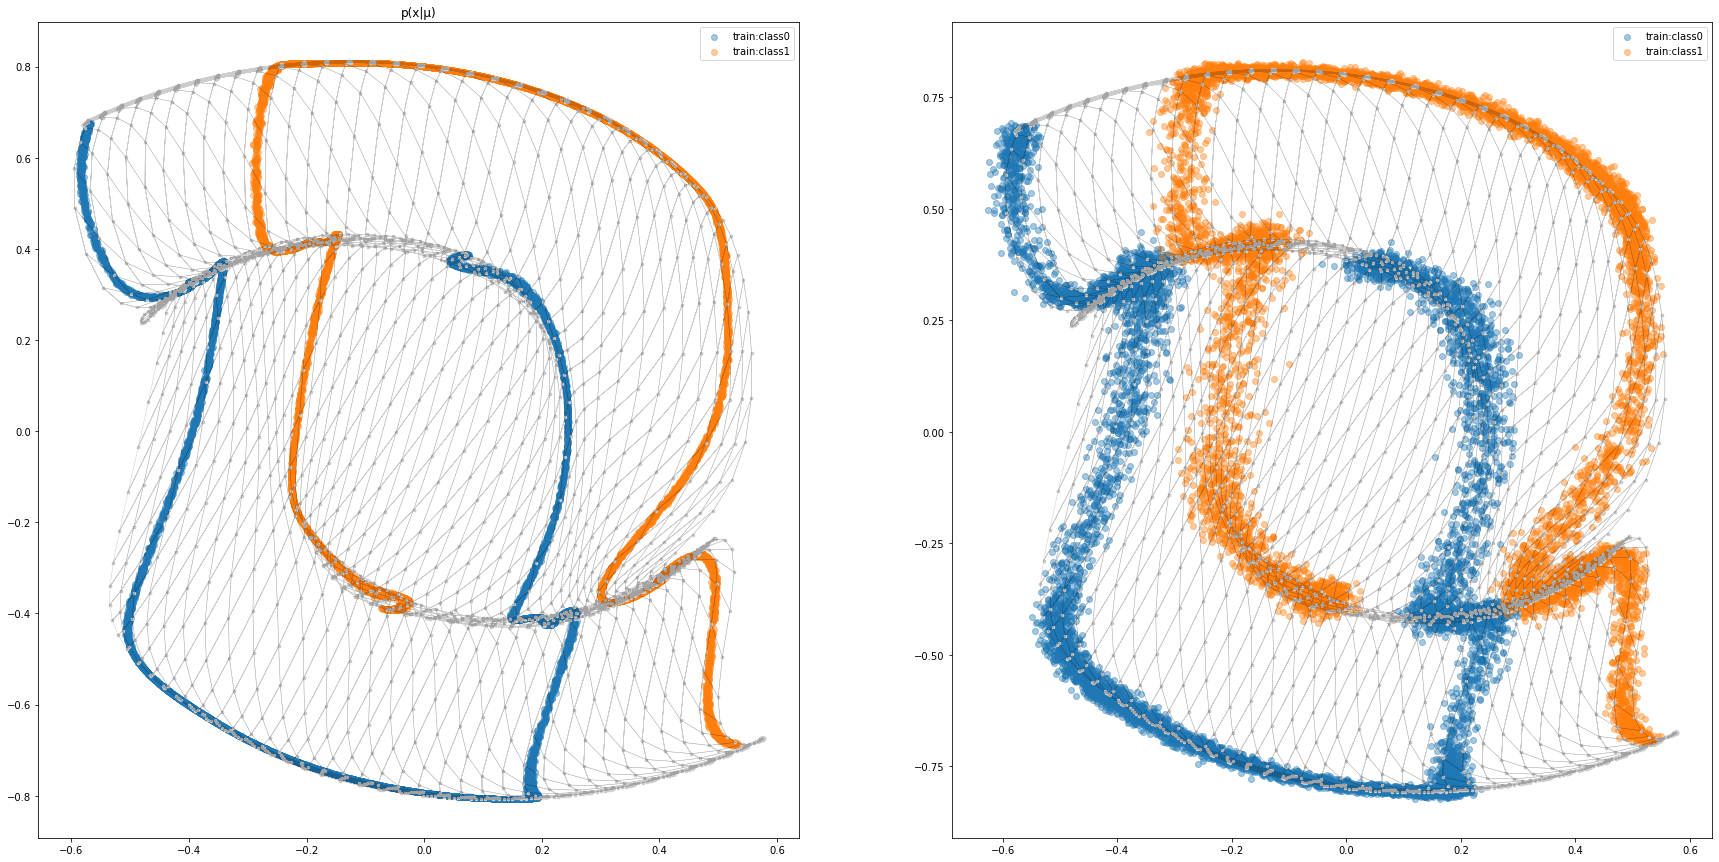

In [322]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(vae_qz_mu_x_train, vae_qz_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(vae_qz_x_train, vae_qz_mu_mesh, label_ids=y_train, ax=ax2)
ax1.set_title('µ')
ax1.set_title('p(x|µ)')
plt.show()

### AVAE

In [323]:
with torch.no_grad():
    avae_qz_x_train, avae_qz_mu_x_train, avae_qz_log_var_x_train = avae.decoder(torch.FloatTensor(train_dataset.examples))
    avae_qz_mesh, avae_qz_mu_mesh, avae_qz_log_var_mesh = avae.decoder(torch.FloatTensor(x_train_meshgrid))

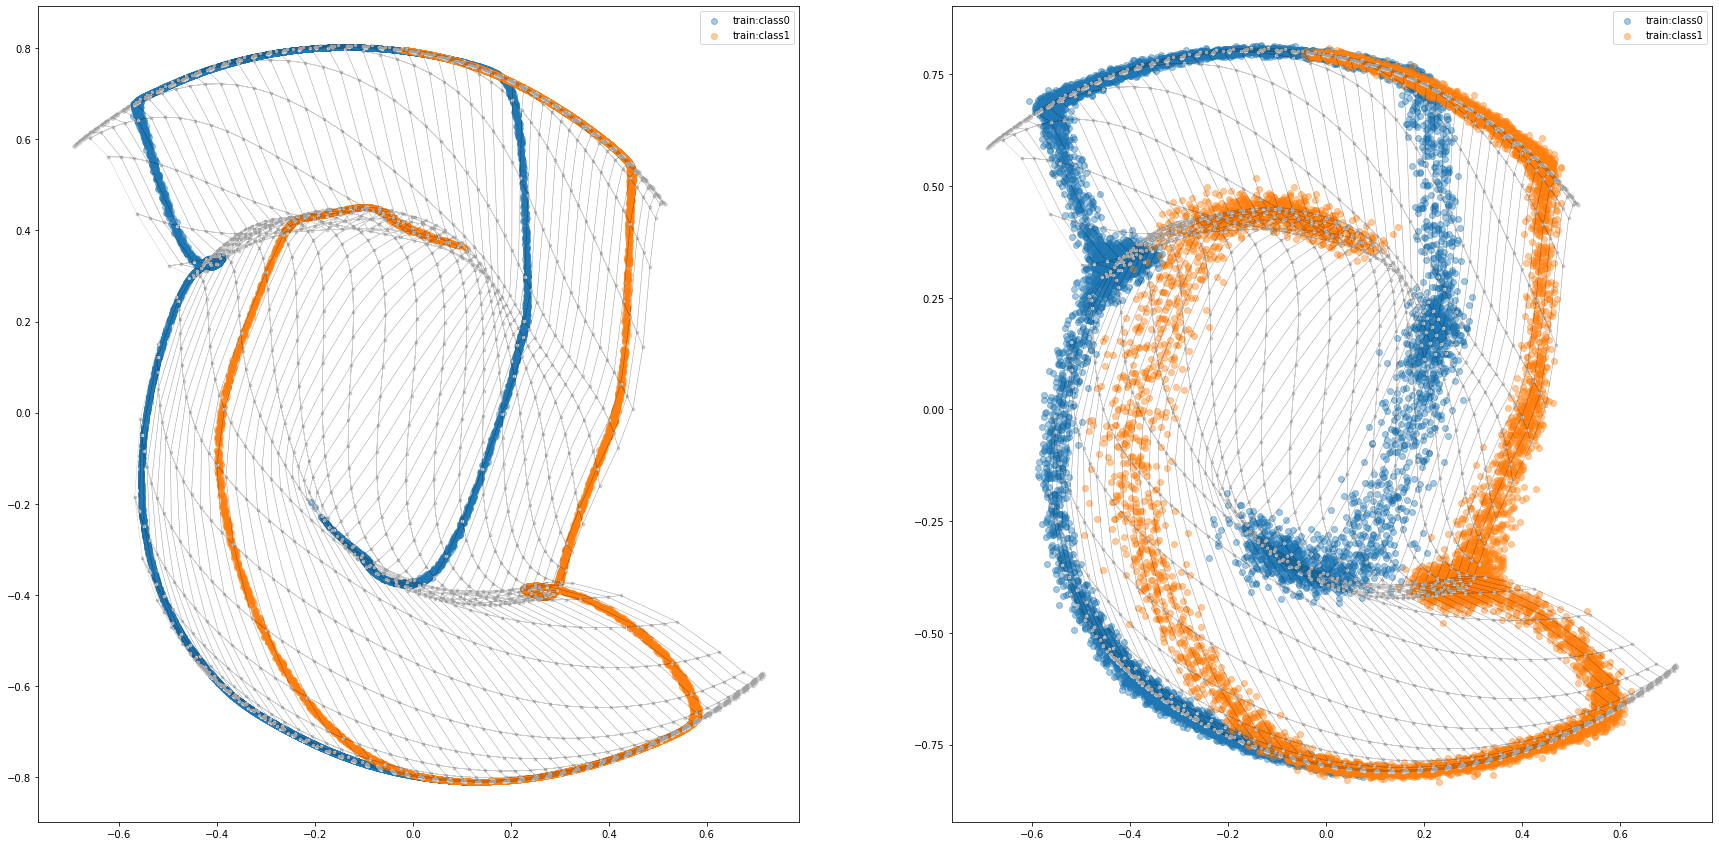

In [324]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(avae_qz_mu_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax1)
plot_vectors_and_mesh(avae_qz_x_train, avae_qz_mu_mesh, label_ids=y_train, ax=ax2)
plt.show()

## Visualize sampling

In [325]:
n_samples = 10000
p_z_samples = torch.randn((n_samples, 2))

In [326]:
with torch.no_grad():
    vae_p_x_samples, vae_p_x_mu, vae_p_x_log_var = vae.decoder(p_z_samples)
    avae_p_x_samples, avae_p_x_mu, avae_p_x_log_var = avae.decoder(p_z_samples)

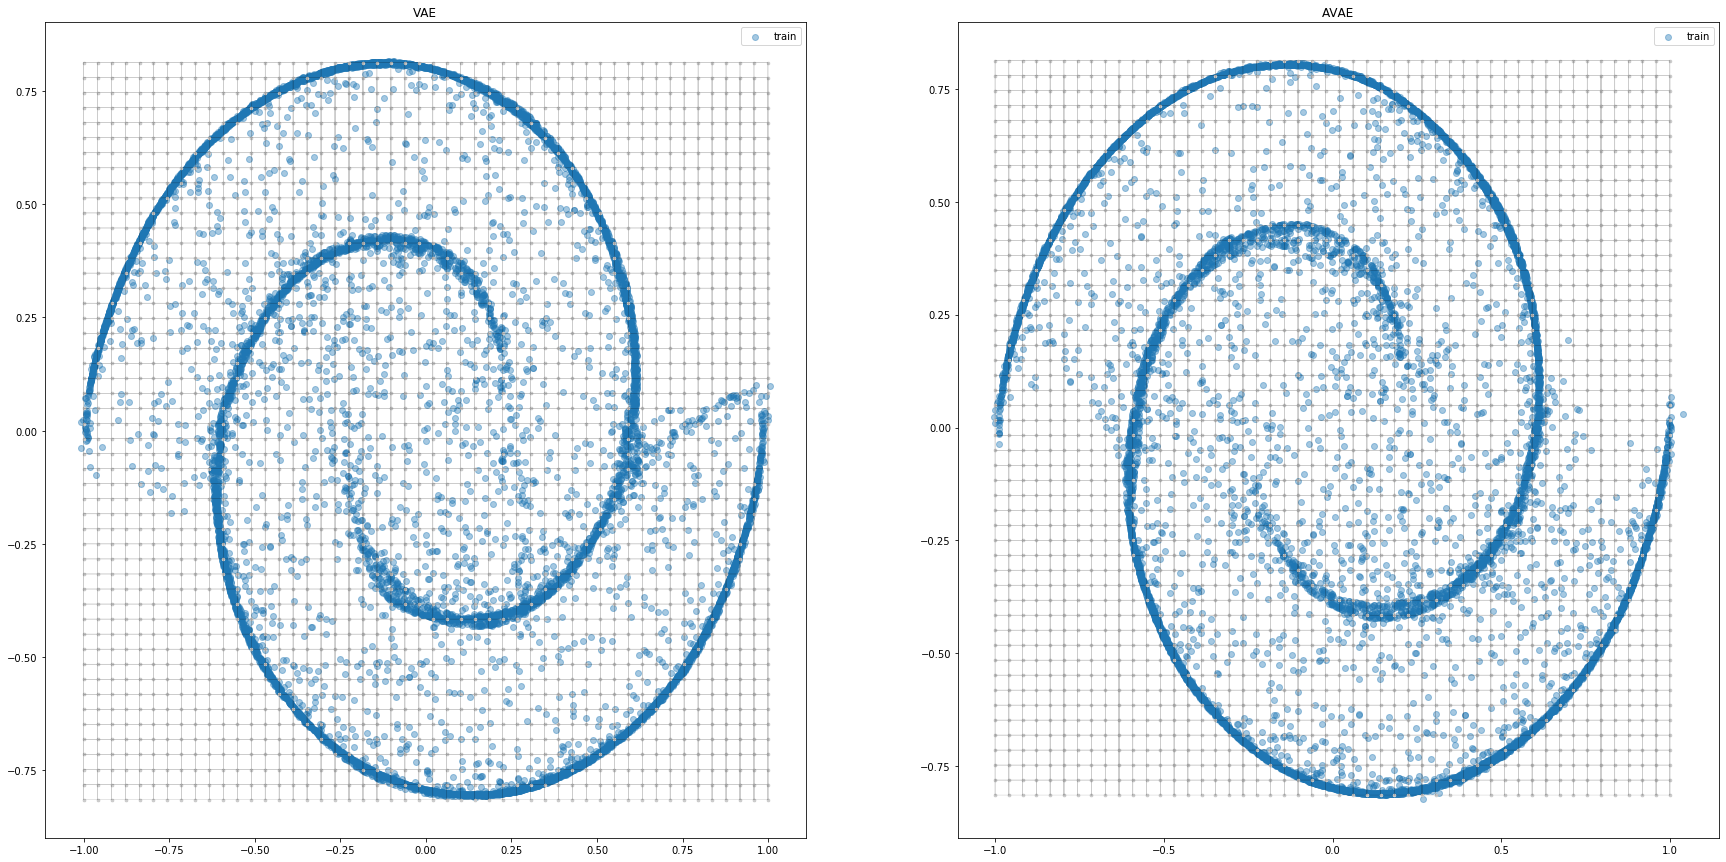

In [327]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
plot_vectors_and_mesh(vae_p_x_mu, x_train_meshgrid, ax=ax1)
plot_vectors_and_mesh(avae_p_x_mu, x_train_meshgrid, ax=ax2)
ax1.set_title('VAE')
ax2.set_title('AVAE')
plt.show()

### Visualize density by ELBO

In [281]:
nx, ny = (500, 500)
importance_samples = 100

x_min, x_max, y_min, y_max = [-2, 2, -2, 2]
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
zv = np.zeros(xv.shape)
zv_var = np.zeros(xv.shape)
with torch.no_grad():
    for j in tqdm.tqdm(range(x.shape[0])):
        inp = np.append(xv[:, j:j+1], yv[:, j:j+1], axis=1)
        inp = torch.FloatTensor(inp)
#        inp = inp.repeat(importance_samples, 1)
        inp = inp.repeat(1, importance_samples).view(-1, inp.shape[1])
        
        px, px_mu, px_sigma = vae.forward(torch.FloatTensor(inp))
        
        kl_divergence = vae.kl_divergence
        likelihood = vari.inference.log_gaussian(px, px_mu, px_sigma)
        elbo = likelihood - kl_divergence
        
        elbo_mean = vari.utilities.log_sum_exp(elbo.view(-1, importance_samples, 1), axis=1, sum_op=torch.sum).view(-1)  # (B, 1, 1)
        elbo_var = vari.utilities.log_sum_exp(elbo.view(-1, importance_samples, 1), axis=1, sum_op=torch.var).view(-1)  # (B, 1, 1)

        zv[:, j] = elbo_mean
        zv_var[:, j] = elbo_var

100%|██████████| 500/500 [00:20<00:00, 24.40it/s]


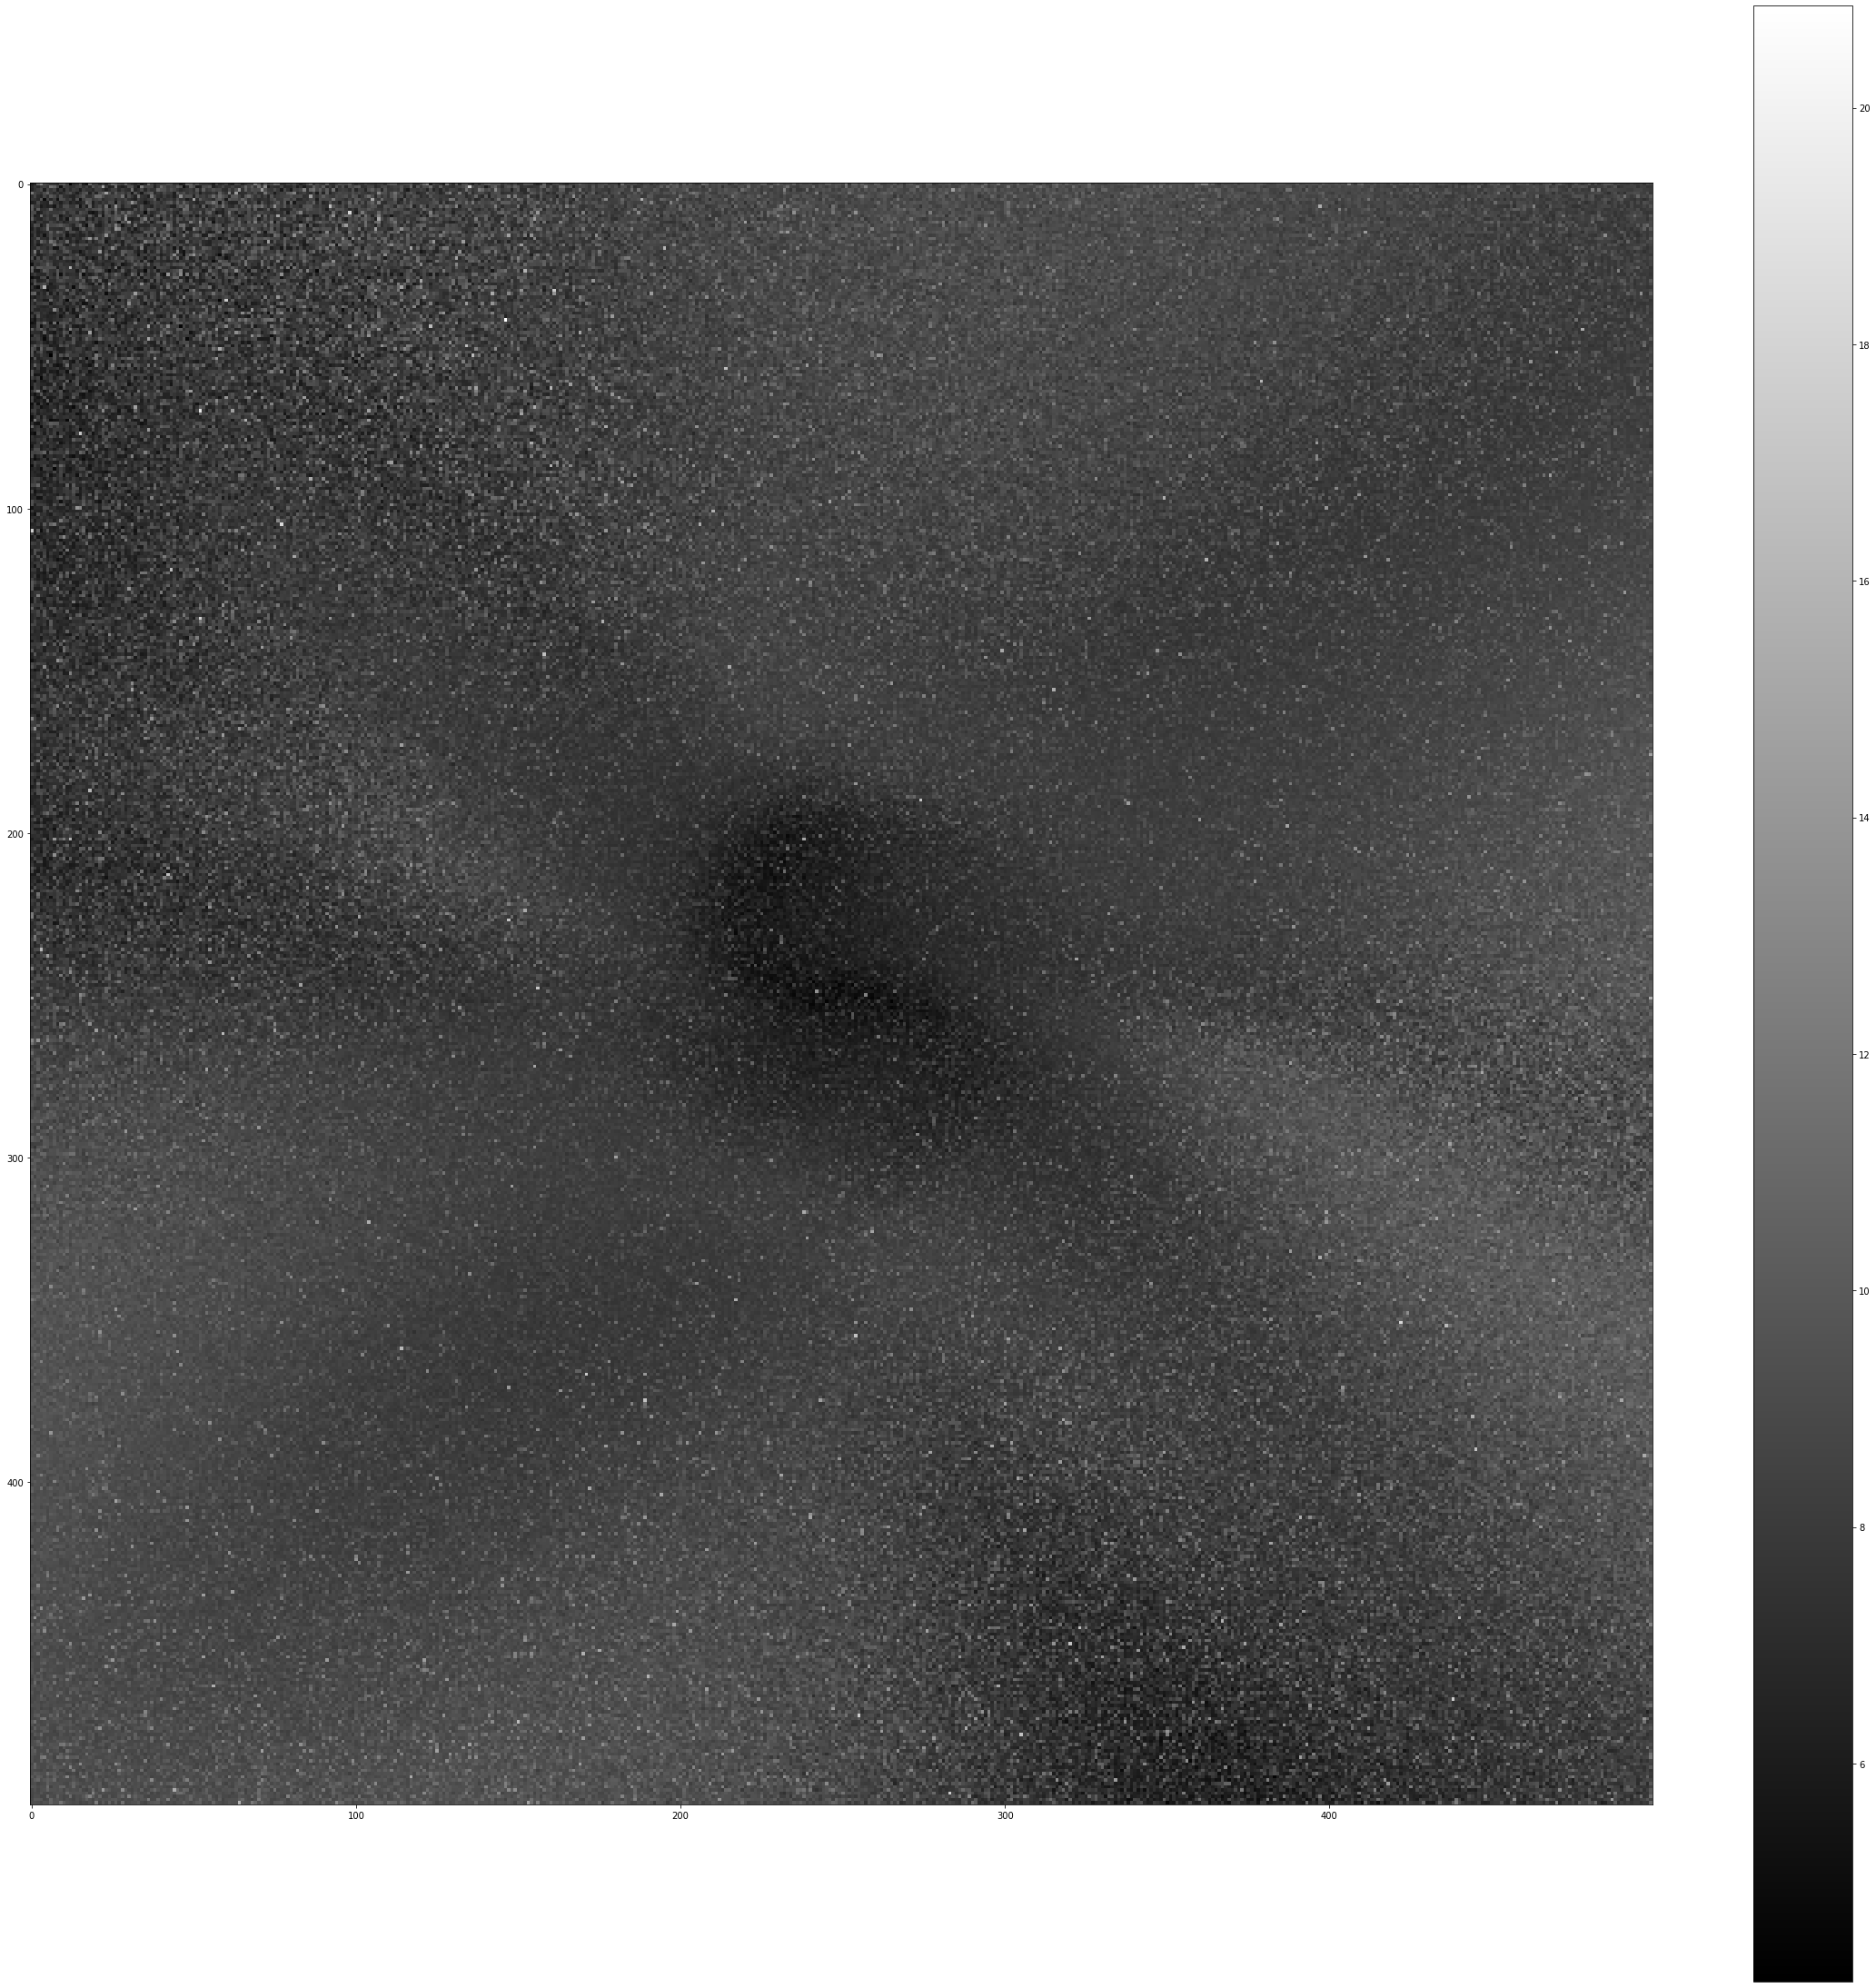

In [282]:
zv_rescaled = zv

#zv_rescaled += zv.min()

zv_rescaled = np.clip(zv_rescaled, -20000., zv_rescaled.max()) # TODO: Do something smarter here!

#zv_rescaled = np.clip(zv_rescaled, 15., zv_rescaled.max())

#zv_rescaled = (zv_rescaled - zv_rescaled.min()) / (zv_rescaled.max() - zv_rescaled.min())
#zv_rescaled = 1-zv_rescaled

#zv_rescaled = np.exp(zv)

plt.figure(figsize=(40, 40))
plt.imshow(zv_rescaled, mpl.cm.get_cmap('binary_r'))
plt.colorbar()
plt.axis(aspect='image');
#plt.axis('off')
plt.show()

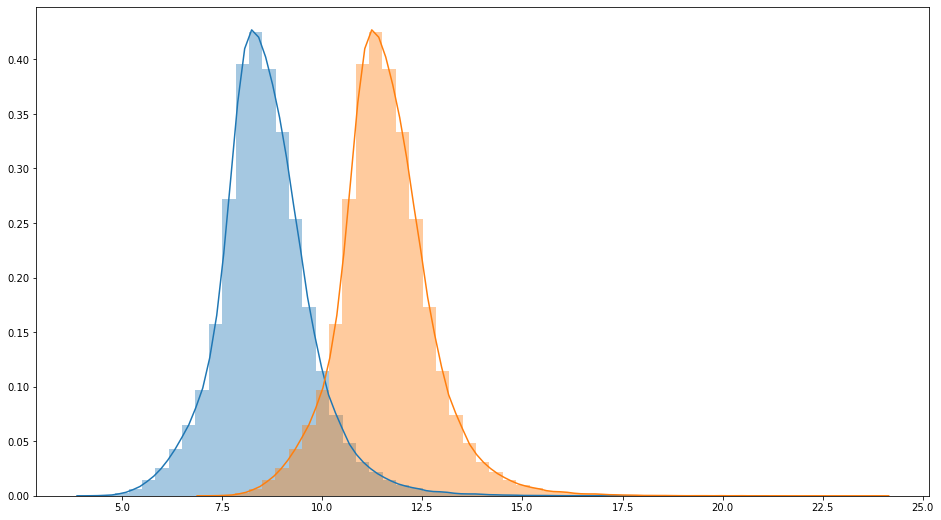

In [333]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
seaborn.distplot(zv.flatten(), ax=ax)

### OOD detection based on ELBO